# Part I - Volatility Arbitrage with improved GBM and MC (Antithetic Variate and Sobol Sequence)

# Black-Scholes-Merton (No Jump) model

## 1. Initial Set-up

In [1]:
%pip install matplotlib 


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install cufflinks


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
cf.set_config_file(offline = True)

# pd.set_option('display.max_rows', 300) # set max row to 300

In [4]:
# import qmc for Sobol sequence
from scipy.stats import norm
from scipy.stats.qmc import Sobol

In [5]:
%pip install tensorflow


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
# package needed for Brownian bridge
import tensorflow.compat.v2 as tf

In [7]:
from scipy.stats import qmc

## 2. The Monte Carlo with Sobol Sequence and Antithetic Variate

This MCOptionPricing would realise the option valuation using the given implied volatillity $\sigma_{implied}$ and the replicating delta using either $\sigma_{actual}$ or $\sigma_{implied}$

In [8]:
# CQF textbook method

class MCOptionPricing:

    def __init__(self, S0:float, strike:float, rate:float, sigma_actual:float, sigma_implied:float, dte:int, nsim:int, timesteps:int=514) -> float:
        self.S0 = S0
        self.K = strike
        self.r = rate
        self.sigma_actual = sigma_actual
        self.sigma_implied = sigma_implied
        self.T = dte
        self.N = nsim # has to be the power of 2 like 64
        self.ts = timesteps
    
    @property
    def rvgenerator(self):
        # Generate Sobol sequences with antithetics without Brownian Bridge
        sobol = Sobol(d = self.ts) # the dimension of each point/timesteps
        sobol_sequences = sobol.random_base2(m=int(np.log2(self.N))) # the number of points/simulations
        antithetic_sobol_sequences = 1.0 - sobol_sequences
        # combine the original and antithetic sequences
        # full_sequences = np.vstack((sobol_sequences, antithetic_sobol_sequences))
        return sobol_sequences, antithetic_sobol_sequences
    
    @property
    def simulate_path(self):
        np.random.seed(2024)
        ''' asset price simulation using actual vol'''
        #define dt
        dt = self.T/self.ts

        #simulate paths
        S = np.zeros((self.N, self.ts))
        S_antithetic = np.zeros((self.N, self.ts))
        S_new = np.zeros((self.N, self.ts))
        S[:,0] = self.S0
        S_antithetic[:,0] = self.S0

        sobol_sequences, antithetic_sobol_sequences = self.rvgenerator

        for i in range(0, self.ts-1):
            z = norm.ppf(sobol_sequences[:,i])
            z_antithetic = norm.ppf(antithetic_sobol_sequences[:,i])
            S[:,i+1] = S[:,i] * np.exp((self.r - self.sigma_actual ** 2) * dt + self.sigma_actual * np.sqrt(dt) * z)
            S_antithetic[:,i+1] = S_antithetic[:,i] * np.exp((self.r - self.sigma_actual ** 2) * dt + self.sigma_actual * np.sqrt(dt) * z_antithetic)
            S_new = (S + S_antithetic) / 2

        return S_new
    
    
    # cannot put @property because we need it as a function
    def asset_delta(self, use_implied_vol = False):
        S = self.simulate_path
        dt = self.T / self.ts
        # chose the appropriate sigma
        sigma = self.sigma_implied if (use_implied_vol) else self.sigma_actual

        # Debugging prints
        print(f"S: {S}")
        print(f"S.shape: {S.shape}")
        print(f"K: {self.K}")
        print(f"r: {self.r}")
        print(f"sigma: {sigma}")
        print(f"T: {self.T}")
        for t in range(self.ts):
            T_t = self.T - (t * dt)  # Time to maturity
            if T_t <= 0:
                continue

        d1 = (np.log(S / self.K) + (self.r + 0.5 * sigma ** 2) * (T_t)) / (sigma * np.sqrt(T_t))
        # More debugging
        print(f"d1: {d1}")

        delta = norm.cdf(d1)  # Delta for a European Call Option

        # Final check before returning
        print(f"delta: {delta}")
        return delta

    @property
    def optionprice(self): # using implied sigma
        S = self.simulate_path
        dt = self.T / self.ts
        option_price = np.zeros(self.ts)

        # Use actual volatility for pricing
        sigma = self.sigma_implied

        for t in range(self.ts):
            T_t = self.T - (t * dt)  # Time to maturity
            if T_t <= 0:
                continue

            # Calculate d1 and d2 for BSM formula
            d1 = (np.log(S[:, t] / self.K) + (self.r + 0.5 * sigma ** 2) * T_t) / (sigma * np.sqrt(T_t))
            d2 = d1 - sigma * np.sqrt(T_t)

            # BSM formula for European call option
            call_prices = S[:, t] * norm.cdf(d1) - self.K * np.exp(-self.r * T_t) * norm.cdf(d2)

            # Average call prices over all simulations for the current time step
            option_price[t] = np.mean(call_prices)
        
        return option_price

    def portfolio_value(self, use_implied_vol = False):
        S = self.simulate_path
        option_price = self.optionprice
        #option_price = option_price.reshape(1,-1)
        delta = self.asset_delta(use_implied_vol = use_implied_vol) # necessary so that the portfolio value can use either implied or actual vol

        option_price_broadcasted = np.tile(option_price, (S.shape[0], 1))

        portfolio = option_price_broadcasted - delta * S

        return portfolio
    
    
    def cashflow_replication(self, use_implied_vol = False):
        S = self.simulate_path
        delta = self.asset_delta(use_implied_vol = use_implied_vol)
        cashflow_replication = np.zeros_like(S)

        for i in range (1, S.shape[0]):
            for j in range(S.shape[1]):
                cashflow_replication[i,j] = S[i,j] * (delta[i,j] - delta[i,j-1])
        return cashflow_replication
    
    
    def cash_account(self,use_implied_vol = False):
        S = self.simulate_path
        portfolio = self.portfolio_value(use_implied_vol = use_implied_vol) # necessary so taht the cash_account follows the binary choice of portfolio value
        cash_account = np.zeros_like(S)
        cashflow_replication = self.cashflow_replication(use_implied_vol = use_implied_vol)
        dt = self.T/self.ts

        cash_account[:,0] = - portfolio[:,0]

        for i in range(cash_account.shape[0]):
            for j in range(1, cash_account.shape[1]):
                cash_account[i,j] = cashflow_replication[i,j] + np.exp(self.r * dt) * cash_account[i,j-1]
        return cash_account

    
    
    def pnl_cum(self, use_implied_vol = False):
        cash_ac = self.cash_account(use_implied_vol = use_implied_vol)
        portfolio = self.portfolio_value(use_implied_vol = use_implied_vol)
        pnl = cash_ac + portfolio
        return pnl
    
    # Gamma based on either implied or actual vol
    def gamma(self, use_implied_vol = False):
        S = self.simulate_path
        dt = self.T / self.ts
        TTE = np.linspace(self.T, (S.shape[0],1)) # create a 128 * 514 matrix for T, each row is the time to expiry array
        TTE_matrix = np.tile(TTE, (S.shape[0],1))
        # chose the appropriate sigma
        sigma = self.sigma_implied if (use_implied_vol) else self.sigma_actual

        # Debugging prints
        print(f"S: {S}")
        print(f"S.shape: {S.shape}")
        print(f"K: {self.K}")
        print(f"r: {self.r}")
        print(f"sigma: {sigma}")
        print(f"T: {self.T}")
        for t in range(self.ts):
            T_t = self.T - (t * dt)  # Time to maturity
            if T_t <= 0:
                continue

        d1 = (np.log(S / self.K) + (self.r + 0.5 * sigma ** 2) * (T_t)) / (sigma * np.sqrt(T_t))

        phi_d1 = norm.pdf(d1) # get the standard normal pdf of d1
        # More debugging
        print(f"d1: {d1}")

        gamma = phi_d1/ (S * sigma * np.sqrt(T_t))  # Gamma for a European Call Option

        # Final check before returning
        print(f"delta: {gamma}")
        return gamma
    
    # Asset return
    @property
    def asset_return(self):
        S = self.simulate_path
        asset_return = np.zeros_like(S)
        asset_return[:,1:] = (self.simulate_path[:,1:] - self.simulate_path[:,:-1]) / self.simulate_path[:,:-1]
        return asset_return
    
    @property
    #the return^2 - implied_vol^2  * timestep_t
    def ret_vol_diff(self):
        ret = self.asset_return
        dt = self.T/self.ts
        result = ret ** 2 - self.sigma_implied * dt
        return result
    
    
    #the PnL
    def pnl_gamma(self, use_implied_vol=False):
        S = self.simulate_path
        gamma = self.gamma(use_implied_vol = use_implied_vol)
        ret_vol_diff = self.ret_vol_diff
        pnl = (1/2) * gamma * S ** 2 * ret_vol_diff
        return pnl

    
    #the discounted PnL
    def pnl_gamma_discounted(self,use_implied_vol=False):
        S = self.simulate_path
        time_steps_gone = np.arange(S.shape[1])
        dt = self.T/self.ts
        gamma_discount = self.gamma(use_implied_vol = use_implied_vol)
        discount_factor = np.exp(-self.r * time_steps_gone * dt)
        pnl_discounted = gamma_discount * discount_factor
        return pnl_discounted
    




Set $K = 100, S_0 = 100, r = 0.05, \sigma_{actual} = 0.20, \sigma_{implied} = 0.35, \tau = 1$ and number of simulation is 2 and 128 respectively.

In [9]:
mc_2sim = MCOptionPricing(100,100,0.05,0.20,0.35,1,2)

In [10]:
mc_128sim = MCOptionPricing(100,100,0.05,0.20,0.35,1,128)

## 3. Sense Check on the Stock Prices, Deltas, Cash and Portfolio Value

In [11]:
delta_actual = mc_128sim.asset_delta
delta_implied = mc_128sim.asset_delta(use_implied_vol = True)

S: [[100.         100.00277624 100.0087709  ... 102.25150008 102.16393275
  101.94892608]
 [100.         100.00238377 100.00433445 ... 101.37331636 101.24942985
  101.23637825]
 [100.         100.00507369 100.00396477 ... 103.18515927 103.21048053
  103.09716283]
 ...
 [100.         100.00530451 100.01732362 ... 103.11806971 103.04590477
  103.05336895]
 [100.         100.00244519 100.00412417 ... 101.01478447 101.0055666
  101.00522881]
 [100.         100.00287511 100.0039034  ... 105.15919755 105.09522336
  104.88393113]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.35
T: 1
d1: [[0.01402008 0.01581839 0.01970126 ... 1.45627379 1.40077648 1.26431024]
 [0.01402008 0.01556417 0.01682769 ... 0.89754523 0.81833534 0.80998483]
 [0.01402008 0.01730652 0.01658824 ... 2.04505906 2.06095288 1.98979451]
 ...
 [0.01402008 0.01745603 0.02524064 ... 2.00292896 1.95758108 1.96227299]
 [0.01402008 0.01560396 0.01669149 ... 0.66804306 0.66213182 0.66191519]
 [0.01402008 0.01588243 0.01654849 ... 3.272

In [12]:
delta_actual()

S: [[100.         100.00363429 100.00499345 ... 101.49929205 101.51683276
  101.37466523]
 [100.         100.00202261 100.00390873 ... 102.54733107 102.71192743
  102.52942773]
 [100.         100.00459077 100.0246445  ... 101.66014967 101.66365937
  101.69142485]
 ...
 [100.         100.00436596 100.00419208 ... 102.3779216  102.43803943
  102.49518051]
 [100.         100.00201075 100.0055147  ... 101.69726053 102.02668781
  101.89310583]
 [100.         100.00357754 100.0099587  ... 116.52098319 116.81521761
  116.4166705 ]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[1.54378382e-02 1.95575147e-02 2.10981661e-02 ... 1.70238814e+00
  1.72197650e+00 1.56311518e+00]
 [1.54378382e-02 1.77306029e-02 1.98686017e-02 ... 2.86687185e+00
  3.04867405e+00 2.84707943e+00]
 [1.54378382e-02 2.06417128e-02 4.33708712e-02 ... 1.88189716e+00
  1.88581064e+00 1.91676571e+00]
 ...
 [1.54378382e-02 2.03868866e-02 2.01897919e-02 ... 2.67944843e+00
  2.74599430e+00 2.80920893e+00]
 [1.54378382e

array([[0.50615856, 0.50780182, 0.50841633, ..., 0.95565868, 0.95746311,
        0.94098725],
       [0.50615856, 0.50707312, 0.5079259 , ..., 0.99792725, 0.99885073,
        0.99779388],
       [0.50615856, 0.50823427, 0.51729705, ..., 0.97007501, 0.97033976,
        0.97236615],
       ...,
       [0.50615856, 0.50813263, 0.50805401, ..., 0.99631282, 0.99698361,
        0.99751683],
       [0.50615856, 0.50706775, 0.50865199, ..., 0.97277697, 0.98898576,
        0.98387756],
       [0.50615856, 0.50777616, 0.51066096, ..., 1.        , 1.        ,
        1.        ]])

In [13]:
delta_implied

array([[0.50559302, 0.50631036, 0.50785916, ..., 0.92734153, 0.91935954,
        0.89694065],
       [0.50559302, 0.50620895, 0.50671296, ..., 0.81528597, 0.79341713,
        0.79102555],
       [0.50559302, 0.50690396, 0.50661745, ..., 0.97957548, 0.98034623,
        0.97669321],
       ...,
       [0.50559302, 0.50696359, 0.51006849, ..., 0.97740754, 0.97486041,
        0.97513464],
       [0.50559302, 0.50622482, 0.50665863, ..., 0.74794695, 0.74605663,
        0.74598721],
       [0.50559302, 0.50633591, 0.50660159, ..., 0.99946715, 0.99938787,
        0.99904151]])

In [14]:
mc_128sim.portfolio_value()

S: [[100.         100.00195276 100.00392069 ... 101.0217023  101.01774263
  101.02220451]
 [100.         100.00258331 100.0051868  ... 108.30045834 108.21562158
  108.31276403]
 [100.         100.01041616 100.02857443 ... 101.07504784 101.13995399
  101.1890392 ]
 ...
 [100.         100.01005575 100.00821223 ... 101.02298824 101.00941929
  101.00604084]
 [100.         100.00267453 100.00670362 ... 104.79856629 104.96307649
  104.82729421]
 [100.         100.00196148 100.01486932 ... 103.89033816 103.9059981
  103.83676454]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01765142 0.01988216 ... 1.16774092 1.16329763 1.16830445]
 [0.01543784 0.01836619 0.02131733 ... 9.05450137 8.96566813 9.06738097]
 [0.01543784 0.02724476 0.04782457 ... 1.22758488 1.30035516 1.35535661]
 ...
 [0.01543784 0.02683625 0.02474666 ... 1.16918388 1.15395715 1.15016562]
 [0.01543784 0.01846959 0.02303666 ... 5.3285091  5.50631591 5.35957907]
 [0.01543784 0.01766131 0.03229212 ... 4.3418

array([[ -34.48742729,  -34.59377382,  -34.74359174, ...,  -85.76553069,
         -85.72050887,  -86.06606645],
       [ -34.48742729,  -34.61968562,  -34.75618876, ..., -100.14978594,
        -100.23106338, -100.45641393],
       [ -34.48742729,  -34.97913377,  -35.8106495 , ..., -104.32438945,
        -106.96291638, -108.53762416],
       ...,
       [ -34.48742729,  -34.96351871,  -34.89952174, ...,  -85.63124754,
         -85.41068972,  -85.4596486 ],
       [ -34.48742729,  -34.62376073,  -34.82056927, ...,  -98.20677498,
         -98.36386163,  -98.48218109],
       [ -34.48742729,  -34.59395475,  -35.18954603, ...,  -97.84791733,
         -97.94576035,  -98.08570361]])

In [15]:
mc_2sim.simulate_path

array([[100.        , 100.00450671, 100.01104869, ..., 102.32860753,
        102.22445317, 102.33337517],
       [100.        , 100.01153643, 100.02043264, ..., 104.79810163,
        104.77350838, 104.81748066]])

## 3.1 Simulation Paths of Stock Price

In [16]:
sim_path_128 = mc_128sim.simulate_path

In [17]:
sim_path_128.shape

(128, 514)

A brief check at the option price

In [18]:
# option price visualisation
option_price_paths_2sim = mc_2sim.optionprice
option_price_paths_128sim = mc_128sim.optionprice
#asset_price_path = mc.simulate_path
#mean_assetprice = mc.mean_assetprice
time_points = np.arange(1,515)

For simulation number = 2 and 128

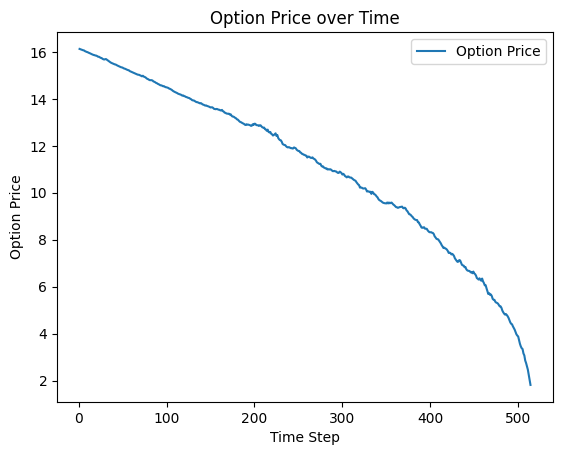

In [19]:
# plot for simulation number = 2
plt.plot(time_points, option_price_paths_2sim, label = 'Option Price')
plt.xlabel('Time Step')
plt.ylabel('Option Price')
plt.title('Option Price over Time')
plt.legend()

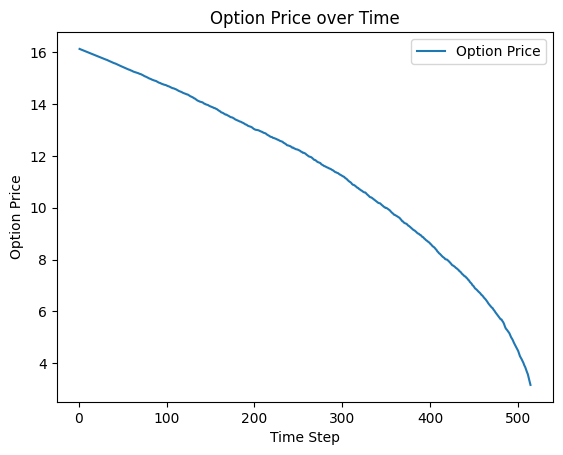

In [20]:
# plot for simulation number = 128
plt.plot(time_points, option_price_paths_128sim, label = 'Option Price')
plt.xlabel('Time Step')
plt.ylabel('Option Price')
plt.title('Option Price over Time')
plt.legend()

Take one simulation of asset price path

In [21]:
path_128sim = mc_128sim.simulate_path

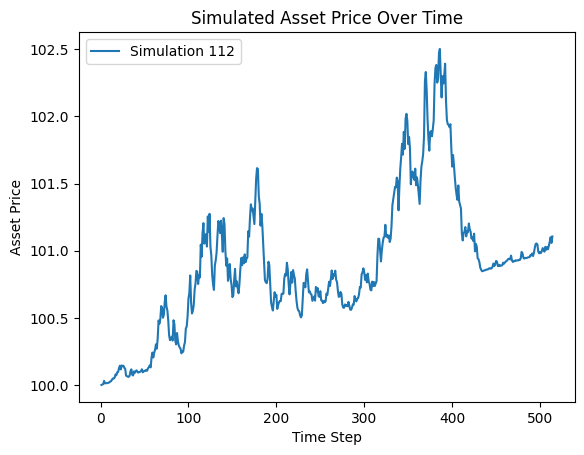

In [22]:
# Check for one simulation: 112
single_sim_path_128sim = path_128sim[111,:]
time_steps = np.arange(1,515)

plt.plot(time_steps, single_sim_path_128sim , label=f'Simulation {111 + 1}')
plt.xlabel('Time Step')
plt.ylabel('Asset Price')
plt.title('Simulated Asset Price Over Time')
plt.legend()
plt.show()

Visualise all 128 simulations of final option price.

In [23]:
option_price_paths_128sim = mc_128sim.optionprice
option_price_paths_128sim.shape

(514,)

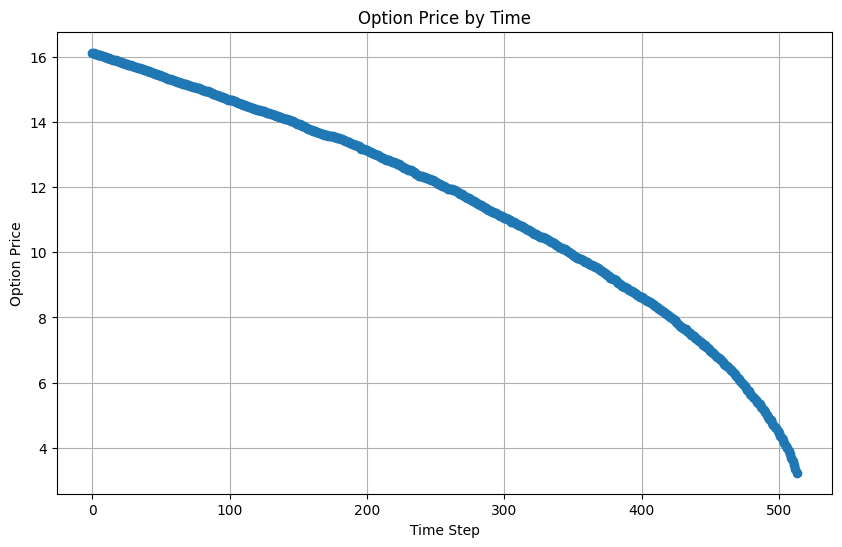

In [24]:
option_price_paths_128sim = mc_128sim.optionprice

plt.figure(figsize = (10,6))
plt.plot(option_price_paths_128sim, marker = 'o', linestyle = '-')
plt.title('Option Price by Time')
plt.xlabel('Time Step')
plt.ylabel('Option Price')
plt.grid(True)
plt.show()

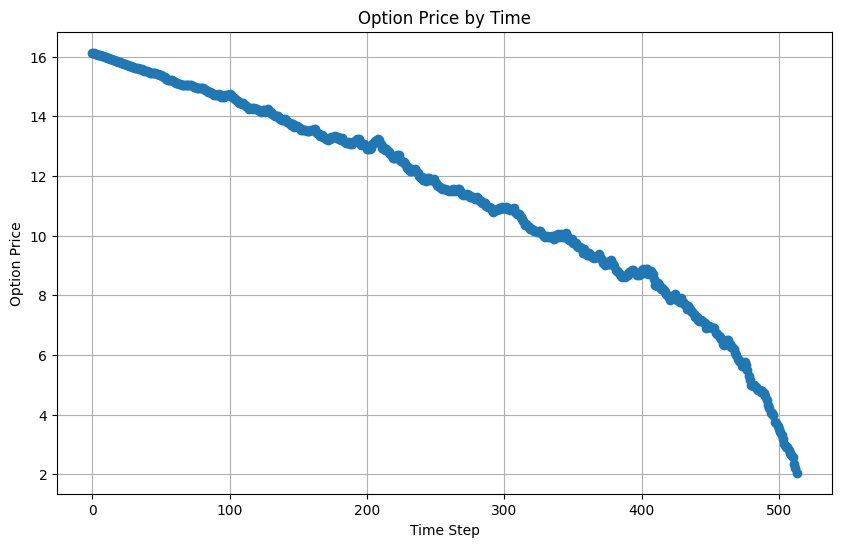

In [25]:
option_price_paths_2sim = mc_2sim.optionprice

plt.figure(figsize = (10,6))
plt.plot(option_price_paths_2sim, marker = 'o', linestyle = '-')
plt.title('Option Price by Time')
plt.xlabel('Time Step')
plt.ylabel('Option Price')
plt.grid(True)
plt.show()

Visualise all the 128 simulations of asset price paths

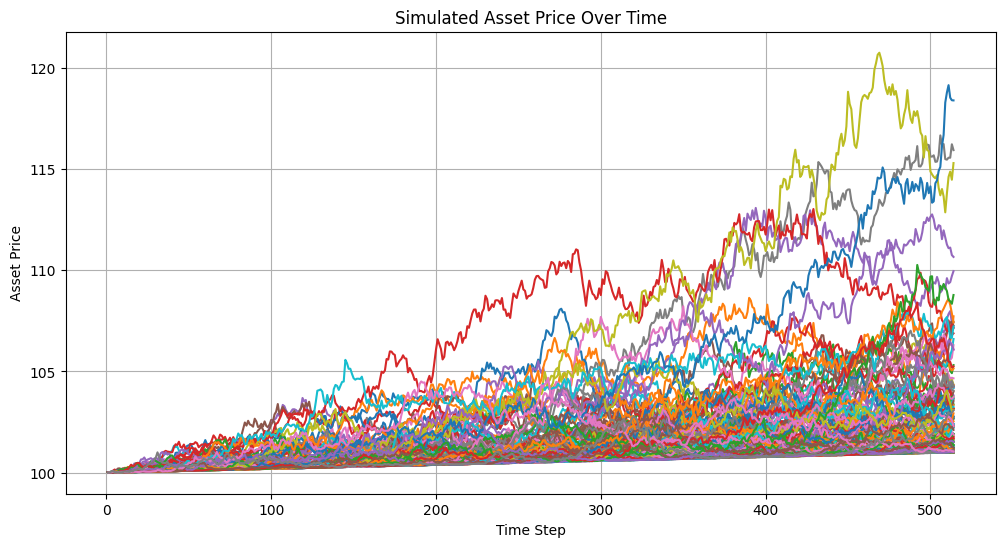

In [26]:
path_128sim = mc_128sim.simulate_path
time_steps = np.arange(1,515)

plt.figure(figsize =(12,6))

for i in range(path_128sim.shape[0]):
    plt.plot(time_steps, path_128sim[i,:], label = f'Simulation {i + 1}')

plt.xlabel('Time Step')
plt.ylabel('Asset Price')
plt.title('Simulated Asset Price Over Time')
plt.grid(True)
plt.show()

## 3.2 Visualisation of Single Simulation, and All Simulations of Accumulative PnL Paths

Check for delta using actual volatility 

In [27]:
delta_128sim = mc_128sim.asset_delta()

S: [[100.         100.00239231 100.00435405 ... 106.45198159 106.41999154
  106.00478077]
 [100.         100.00678763 100.01919275 ... 101.64542483 101.63541554
  101.5603392 ]
 [100.         100.0025599  100.00502875 ... 101.56448179 101.42585607
  101.45301668]
 ...
 [100.         100.0024861  100.00628836 ... 101.02540689 101.04328603
  101.03527219]
 [100.         100.00655299 100.00503375 ... 103.30216545 103.18440803
  102.72462032]
 [100.         100.00243017 100.0154068  ... 101.69391619 101.63293379
  101.53310156]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01814968 0.02037339 ... 7.1030031  7.06893263 6.62578793]
 [0.01543784 0.02313189 0.03719224 ... 1.86547679 1.8543136  1.77054716]
 [0.01543784 0.01833964 0.02113817 ... 1.77517087 1.62034267 1.65069446]
 ...
 [0.01543784 0.01825599 0.02256597 ... 1.17189781 1.19195774 1.18296686]
 [0.01543784 0.02286592 0.02114384 ... 3.69822467 3.56893075 3.06268167]
 [0.01543784 0.0181926  0.03290131 ... 1.919

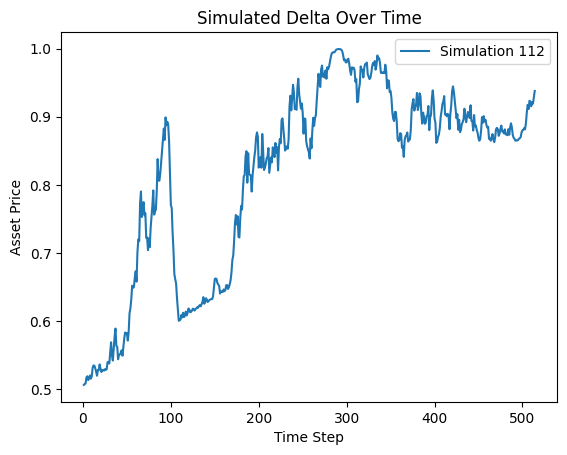

In [28]:
delta_128sim_path = delta_128sim[111,:]
time_steps = np.arange(1,515)

plt.plot(time_steps, delta_128sim_path, label=f'Simulation {111 + 1}')
plt.xlabel('Time Step')
plt.ylabel('Asset Price')
plt.title('Simulated Delta Over Time')
plt.legend()
plt.show()

S: [[100.         100.00195347 100.0064783  ... 101.25289186 101.43958854
  101.32858796]
 [100.         100.00228747 100.00710492 ... 102.91541571 102.88478811
  102.97397952]
 [100.         100.00458475 100.00637821 ... 101.96714831 102.11837392
  102.14485845]
 ...
 [100.         100.00437633 100.01620403 ... 104.55037089 104.31908458
  104.18210474]
 [100.         100.00233157 100.00912207 ... 102.74430497 102.6858785
  102.72826066]
 [100.         100.00196339 100.00394982 ... 101.1000037  101.07294762
  101.10220527]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01765223 0.02278126 ... 1.42686551 1.63568962 1.51157954]
 [0.01543784 0.01803083 0.02349153 ... 3.27303137 3.23929109 3.33751907]
 [0.01543784 0.02063489 0.02266781 ... 2.22370525 2.39169964 2.42109534]
 ...
 [0.01543784 0.02039865 0.03380489 ... 5.05972428 4.8086763  4.65972999]
 [0.01543784 0.01808082 0.02577795 ... 3.08440183 3.01992155 3.06669875]
 [0.01543784 0.01766348 0.01991518 ... 1.2555

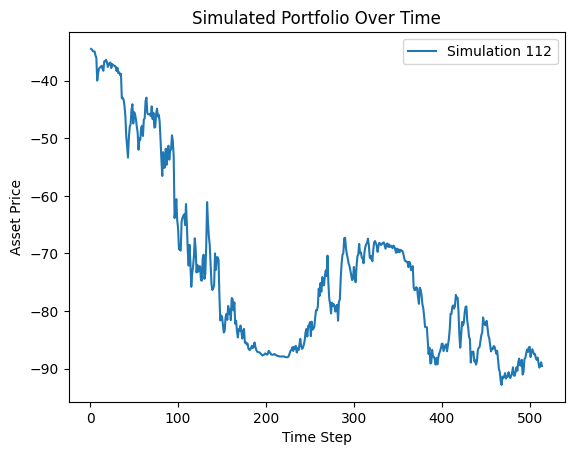

In [29]:
portfolio_128sim_path = mc_128sim.portfolio_value()
portfolio_128sim_path = portfolio_128sim_path[111,:]
time_steps = np.arange(1,515)

plt.plot(time_steps, portfolio_128sim_path, label=f'Simulation {111 + 1}')
plt.xlabel('Time Step')
plt.ylabel('Asset Price')
plt.title('Simulated Portfolio Over Time')
plt.legend()
plt.show()

In [30]:
cashflow_replication_128sim_path = mc_128sim.cashflow_replication

In [31]:
mc_128sim.cashflow_replication()

S: [[100.         100.00246121 100.01306362 ... 101.08780016 101.07230466
  101.04747785]
 [100.         100.00525919 100.00556928 ... 102.22981897 102.47088041
  102.5405527 ]
 [100.         100.00369425 100.00631852 ... 102.07022886 102.07003482
  102.13997843]
 ...
 [100.         100.00347566 100.00392678 ... 101.07456742 101.0653931
  101.07522077]
 [100.         100.00519637 100.01762775 ... 101.14682932 101.19711529
  101.19988847]
 [100.         100.00257112 100.00757054 ... 102.02062693 102.04320259
  102.32240869]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01822778 0.03024551 ... 1.24188599 1.2245083  1.19666033]
 [0.01543784 0.02139938 0.02175088 ... 2.51534323 2.78233027 2.85937866]
 [0.01543784 0.01962548 0.02260015 ... 2.33824299 2.33802748 2.41567948]
 ...
 [0.01543784 0.0193777  0.01988906 ... 1.22704608 1.21675637 1.22777884]
 [0.01543784 0.02132818 0.03541852 ... 1.30806079 1.36440356 1.36750995]
 [0.01543784 0.01835237 0.02401931 ... 2.2831

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.91719079e+01,  2.37828638e-01,  1.40233692e-02, ...,
         5.78797165e-01,  3.28077198e-01,  5.82321524e-02],
       [-4.85988498e+01,  1.67040589e-01,  1.18650898e-01, ...,
        -2.22166154e-02, -5.93265765e-04,  1.96726547e-01],
       ...,
       [-3.84076437e+01,  1.57157201e-01,  2.03982213e-02, ...,
         8.14210796e-01, -1.97035106e-01,  2.11093072e-01],
       [-4.08108678e+01,  2.34992454e-01,  5.61932938e-01, ...,
        -1.61622370e-01,  9.42156316e-01,  4.99797741e-02],
       [-4.89418646e+01,  1.16262197e-01,  2.26039422e-01, ...,
        -6.61109849e-01,  7.31642645e-02,  6.19166058e-01]])

S: [[100.         100.00194826 100.00685174 ... 101.66417982 101.61513601
  101.55646552]
 [100.         100.00436641 100.0081888  ... 105.22887612 105.11548029
  105.0605754 ]
 [100.         100.0020358  100.0041299  ... 101.32883145 101.38640602
  101.31674037]
 ...
 [100.         100.00201556 100.00705525 ... 101.65813314 101.50450121
  101.82688535]
 [100.         100.00447533 100.00995997 ... 101.3887235  101.41236935
  101.46634636]
 [100.         100.0019456  100.00470678 ... 105.20856803 105.22625574
  105.28503837]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01764632 0.02320455 ... 1.88639096 1.83169281 1.76622343]
 [0.01543784 0.0203874  0.0247201  ... 5.79301089 5.67078933 5.61156374]
 [0.01543784 0.01774555 0.0201193  ... 1.51185194 1.57624305 1.49832469]
 ...
 [0.01543784 0.01772261 0.02343523 ... 1.87964857 1.70820575 2.06766625]
 [0.01543784 0.02051086 0.02672768 ... 1.57883413 1.60526834 1.66558731]
 [0.01543784 0.01764331 0.02077322 ... 5.771

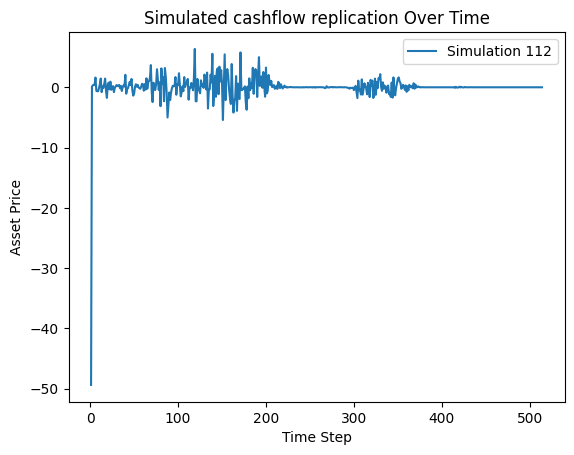

In [32]:
cashflow_replication_128sim_path = mc_128sim.cashflow_replication()
cashflow_replication_128sim_path = cashflow_replication_128sim_path[111,:]

time_steps = np.arange(1,515)

plt.plot(time_steps, cashflow_replication_128sim_path, label=f'Simulation {111 + 1}')
plt.xlabel('Time Step')
plt.ylabel('Asset Price')
plt.title('Simulated cashflow replication Over Time')
plt.legend()
plt.show()

In [33]:
mc_128sim.cash_account()

S: [[100.         100.00561074 100.00889413 ... 101.30533104 101.26643388
  101.27563641]
 [100.         100.00319999 100.0101438  ... 101.26825694 101.38514817
  101.33642243]
 [100.         100.00464628 100.00863591 ... 107.41275889 107.37587292
  107.14034431]
 ...
 [100.         100.00498738 100.00924618 ... 104.66004651 104.74378051
  105.44511736]
 [100.         100.00310005 100.00399108 ... 101.01272632 101.03661988
  101.00682547]
 [100.         100.00572101 100.00592474 ... 101.1637359  101.17769382
  101.15384777]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.02179788 0.02551958 ... 1.48555868 1.44202549 1.45232635]
 [0.01543784 0.01906522 0.02693605 ... 1.44406621 1.57483666 1.52034375]
 [0.01543784 0.02070464 0.0252269  ... 8.1215195  8.08258527 7.83366213]
 ...
 [0.01543784 0.02109128 0.02591862 ... 5.17857679 5.26923327 6.02571781]
 [0.01543784 0.01895194 0.01996195 ... 1.1576684  1.18447891 1.15104619]
 [0.01543784 0.02192286 0.0221538  ... 1.327

array([[34.48742729, 34.49078226, 34.49413756, ..., 36.24505661,
        36.24858256, 36.25210886],
       [34.48742729, 34.63691473, 34.95131455, ..., 82.39211088,
        81.5501941 , 79.76531385],
       [34.48742729, 34.6764912 , 34.72182716, ..., 87.70767181,
        87.71620416, 87.72473464],
       ...,
       [34.48742729, 34.6794156 , 34.87634334, ..., 81.86161021,
        81.81866947, 82.70697272],
       [34.48742729, 34.62939839, 34.91664626, ..., 77.24394401,
        75.73805365, 75.33881857],
       [34.48742729, 34.8777198 , 34.67072224, ..., 74.60744495,
        74.86635273, 75.16036743]])

S: [[100.         100.0022174  100.00424857 ... 103.34859347 103.00047133
  103.00907998]
 [100.         100.0026477  100.00409747 ... 105.35266819 105.46021218
  105.14464249]
 [100.         100.00591673 100.03383312 ... 106.97318843 106.41274
  106.16040357]
 ...
 [100.         100.00631504 100.00613478 ... 127.29780326 126.61977903
  125.83321426]
 [100.         100.00260546 100.00526846 ... 101.02658501 101.02711503
  101.04917677]
 [100.         100.00217065 100.0064959  ... 100.99953992 101.00294299
  101.0032673 ]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[1.54378382e-02 1.79514045e-02 2.02538272e-02 ... 3.74916065e+00
  3.36667856e+00 3.37615247e+00]
 [1.54378382e-02 1.84391731e-02 2.00825424e-02 ... 5.92628755e+00
  6.04194419e+00 5.70223384e+00]
 [1.54378382e-02 2.21447145e-02 5.37838461e-02 ... 7.65666788e+00
  7.06120809e+00 6.79208353e+00]
 ...
 [1.54378382e-02 2.25962089e-02 2.23918779e-02 ... 2.73753800e+01
  2.67699903e+01 2.60636127e+01]
 [1.54378382e-02

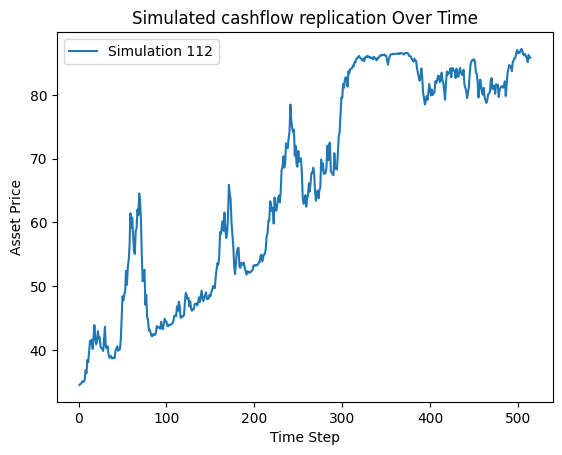

In [34]:
cash_account_128sim_path = mc_128sim.cash_account()
cash_account_128sim_path = cash_account_128sim_path[111,:]

time_steps = np.arange(1,515)

plt.plot(time_steps, cash_account_128sim_path, label=f'Simulation {111 + 1}')
plt.xlabel('Time Step')
plt.ylabel('Asset Price')
plt.title('Simulated cashflow replication Over Time')
plt.legend()
plt.show()

In [35]:
mc_128sim.pnl_cum()

S: [[100.         100.0025352  100.01855435 ... 102.95700356 103.15252365
  103.33388762]
 [100.         100.00203668 100.00794456 ... 101.29300333 101.27298924
  101.24263758]
 [100.         100.00479704 100.00454154 ... 104.9972381  105.18034081
  105.05766984]
 ...
 [100.         100.00488859 100.01272034 ... 101.15740952 101.09422778
  101.09846947]
 [100.         100.00200457 100.00776907 ... 101.31111996 101.3226042
  101.34191888]
 [100.         100.00250634 100.00624432 ... 101.02687302 101.07965827
  101.18548388]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01831165 0.03646869 ... 3.31882972 3.53389733 3.7330294 ]
 [0.01543784 0.01774655 0.02444326 ... 1.47176348 1.44936333 1.41538473]
 [0.01543784 0.02087553 0.02058592 ... 5.5432037  5.74071414 5.60842866]
 ...
 [0.01543784 0.02097931 0.02985642 ... 1.31991767 1.24909356 1.25384971]
 [0.01543784 0.01771015 0.02424435 ... 1.49203614 1.50488522 1.52649206]
 [0.01543784 0.01827893 0.02251604 ... 1.1735

array([[ 0.00000000e+00, -1.12220161e-01, -2.14150915e-01, ...,
        -6.22562627e+01, -6.26289932e+01, -6.26525347e+01],
       [ 0.00000000e+00,  5.18004867e-01,  1.07569990e+00, ...,
        -9.03959162e+00, -1.10364801e+01, -1.24236418e+01],
       [ 0.00000000e+00, -1.53020065e-01, -5.85086936e-02, ...,
        -5.77111844e+00, -5.09595799e+00, -6.33856862e+00],
       ...,
       [ 0.00000000e+00, -1.42741515e-01, -3.87357526e-01, ...,
        -1.59265967e+01, -1.62564170e+01, -1.56904608e+01],
       [ 0.00000000e+00,  5.44078083e-01,  8.25471390e-03, ...,
        -9.33776599e+00, -9.47019378e+00, -9.54849027e+00],
       [ 0.00000000e+00,  7.89948830e-01,  1.41087234e-01, ...,
        -1.00788656e+01, -1.02942206e+01, -1.03463630e+01]])

S: [[100.         100.00196339 100.00910419 ... 101.76280273 101.8498357
  101.81438485]
 [100.         100.00454665 100.01185065 ... 109.04606593 109.06884479
  109.01913517]
 [100.         100.0019702  100.00415328 ... 101.6215002  101.53753719
  101.45003496]
 ...
 [100.         100.00198648 100.01173712 ... 102.81333989 102.41333848
  102.17941036]
 [100.         100.00440511 100.01210145 ... 102.6374285  102.71093541
  102.65139666]
 [100.         100.00195314 100.00408004 ... 103.37279002 103.64242894
  103.62036895]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01766347 0.02575768 ... 1.99630441 2.09321264 2.05374933]
 [0.01543784 0.02059171 0.02887068 ... 9.83225291 9.85593    9.80425383]
 [0.01543784 0.01767119 0.02014581 ... 1.83879223 1.74509356 1.64736281]
 ...
 [0.01543784 0.01768965 0.028742   ... 3.16054252 2.71865695 2.45943371]
 [0.01543784 0.02043126 0.02915494 ... 2.9664236  3.04757921 2.98184967]
 [0.01543784 0.01765186 0.02006279 ... 3.7756

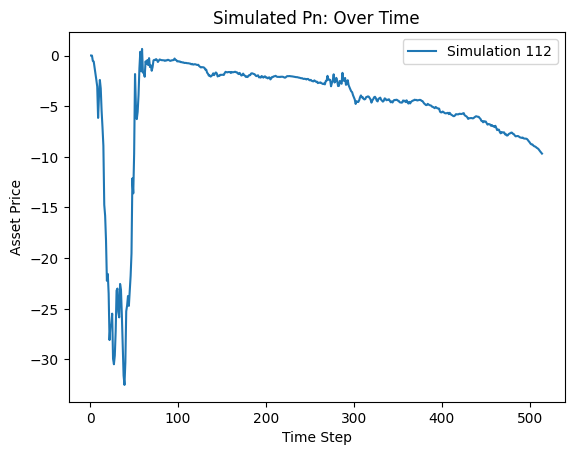

In [36]:
pnl_128sim_path = mc_128sim.pnl_cum()
pnl_128sim_path = pnl_128sim_path[111,:]

time_steps = np.arange(1,515)

plt.plot(time_steps, pnl_128sim_path, label=f'Simulation {111 + 1}')
plt.xlabel('Time Step')
plt.ylabel('Asset Price')
plt.title('Simulated Pn: Over Time')
plt.legend()
plt.show()

In [37]:
pnl_128sim_path.shape

(514,)

Visualise all simulations of Accumulative PnL

S: [[100.         100.0044342  100.00847381 ... 102.63346019 102.50163018
  102.70033596]
 [100.         100.01677492 100.00550358 ... 101.12896171 101.15568772
  101.13917078]
 [100.         100.00240886 100.00458292 ... 101.05636421 101.03273633
  101.03104065]
 ...
 [100.         100.00238984 100.00389113 ... 101.00294839 101.0243083
  101.03678635]
 [100.         100.01750199 100.03230648 ... 101.00122213 101.00377839
  101.00529734]
 [100.         100.0045353  100.01829183 ... 102.46671789 102.20129917
  102.30801943]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.02046424 0.02504316 ... 2.96204072 2.81634192 3.03588042]
 [0.01543784 0.03445193 0.0216764  ... 1.28803432 1.31798819 1.29947734]
 [0.01543784 0.01816844 0.02063282 ... 1.20662886 1.18012168 1.17821912]
 ...
 [0.01543784 0.01814687 0.01984866 ... 1.14669495 1.17066511 1.18466567]
 [0.01543784 0.03527598 0.05205386 ... 1.14475751 1.14762647 1.14933119]
 [0.01543784 0.02057884 0.03617116 ... 2.7777

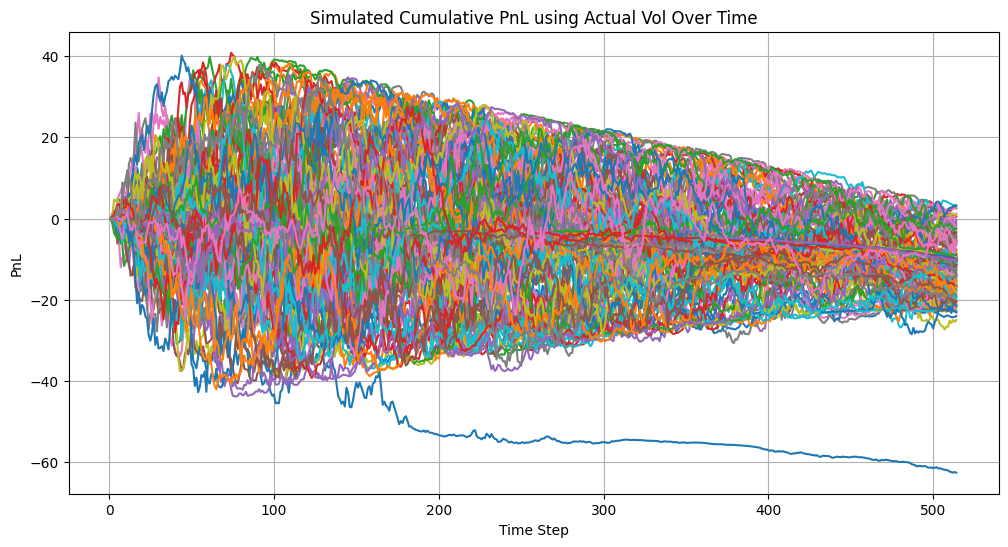

In [38]:
pnl_128sim_path  = mc_128sim.pnl_cum()
time_steps = np.arange(1,515)

plt.figure(figsize =(12,6))

for i in range(pnl_128sim_path.shape[0]):
    plt.plot(time_steps, pnl_128sim_path[i,:], label = f'Simulation {i + 1}')

plt.xlabel('Time Step')
plt.ylabel('PnL')
plt.title('Simulated Cumulative PnL using Actual Vol Over Time')
plt.grid(True)
plt.show()

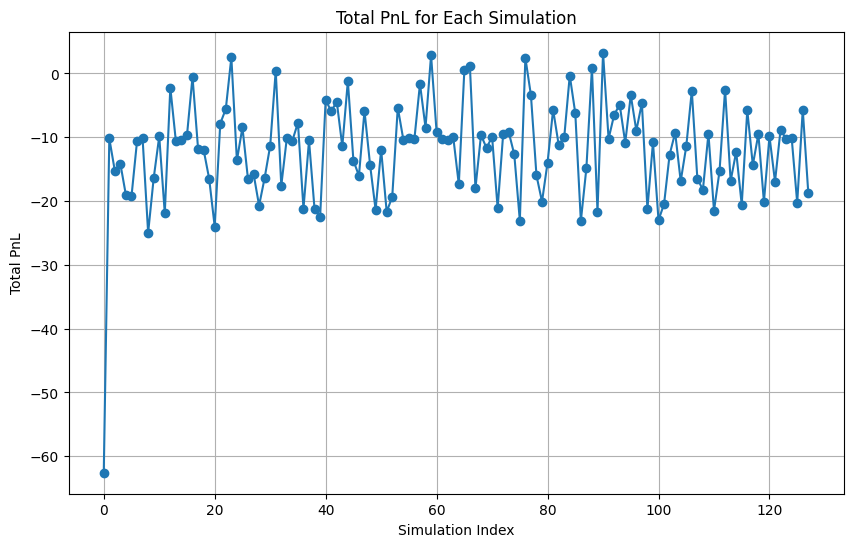

In [39]:
#total PnL
total_pnl_cum = pnl_128sim_path[:,-1]
plt.figure(figsize = (10,6))
plt.plot(total_pnl_cum, marker = 'o', linestyle = '-')
plt.title('Total PnL for Each Simulation')
plt.xlabel('Simulation Index')
plt.ylabel('Total PnL')
plt.grid(True)
plt.show()

It looks like the total PnL for each simulation has converged well

## 4. Delta Hedging

## 4.1. Hedging with $\Delta_{actual}$

S: [[100.         100.00335976 100.00419058 ... 101.51529635 101.68175903
  101.69844191]
 [100.         100.00245825 100.00397949 ... 103.08940563 103.1009237
  103.24890833]
 [100.         100.03188702 100.05754695 ... 101.05651366 101.03742384
  101.1233385 ]
 ...
 [100.         100.02082054 100.00783445 ... 101.24778454 101.16458442
  101.22939517]
 [100.         100.0025579  100.00462737 ... 101.96872778 102.01319281
  102.19433269]
 [100.         100.00331465 100.00617055 ... 102.83387768 103.0005108
  103.08929211]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01924633 0.02018809 ... 1.72026087 1.90599048 1.92458752]
 [0.01543784 0.01822442 0.01994881 ... 3.46451355 3.47717819 3.6397683 ]
 [0.01543784 0.05157852 0.08065305 ... 1.2067965  1.1853809  1.28173096]
 ...
 [0.01543784 0.0390371  0.02431845 ... 1.42114745 1.32795764 1.4005567 ]
 [0.01543784 0.01833738 0.0206832  ... 2.22546115 2.27488181 2.47598733]
 [0.01543784 0.01919519 0.02243242 ... 3.18318

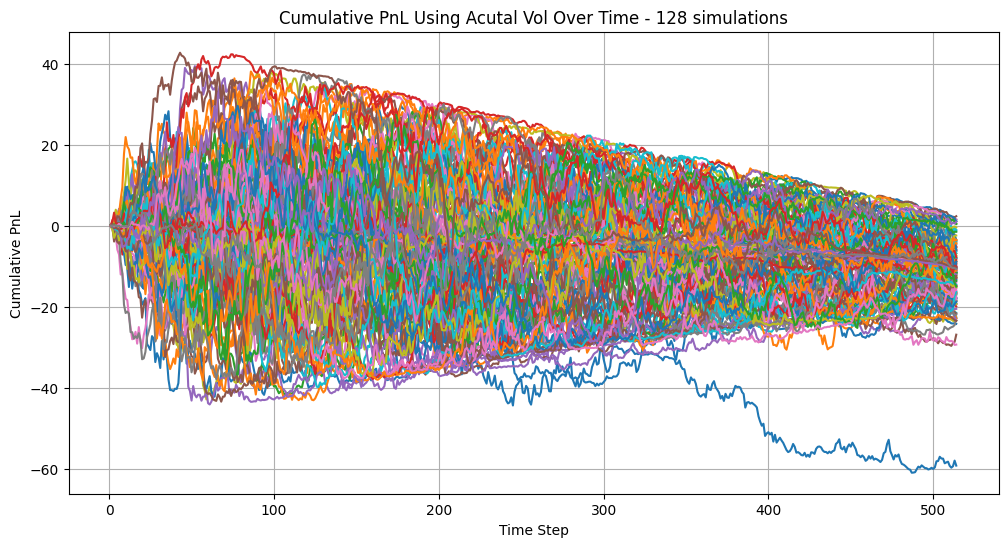

In [40]:
# plot the daily pnl of all simulations
daily_pnl_128sim_actual = mc_128sim.pnl_cum()
time_steps = np.arange(1,515)

plt.figure(figsize =(12,6))

for i in range(daily_pnl_128sim_actual.shape[0]):
    plt.plot(time_steps, daily_pnl_128sim_actual[i,:], label = f'Simulation {i + 1}')

plt.xlabel('Time Step')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL Using Acutal Vol Over Time - 128 simulations')
plt.grid(True)
plt.show()

S: [[100.         100.00332725 100.00396562 ... 101.06685215 101.09861472
  101.08158457]
 [100.         100.00313817 100.00396396 ... 101.08806369 101.18479554
  101.15398596]
 [100.         100.00473101 100.01156754 ... 101.02587559 101.02091413
  101.01174603]
 ...
 [100.         100.00470489 100.00586839 ... 103.38778443 103.66166561
  103.7264217 ]
 [100.         100.00305489 100.00587348 ... 102.69780656 102.79417169
  102.58803223]
 [100.         100.00328915 100.06193553 ... 101.61409272 101.62204734
  101.49431683]]
S.shape: (256, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01920948 0.01993309 ... 1.21839287 1.25401256 1.23491573]
 [0.01543784 0.01899515 0.01993121 ... 1.2421815  1.35060251 1.31608113]
 [0.01543784 0.02080068 0.0285498  ... 1.17242373 1.1668565  1.15656831]
 ...
 [0.01543784 0.02077108 0.02208992 ... 3.79213908 4.09203456 4.16282562]
 [0.01543784 0.01890075 0.02209569 ... 3.03308851 3.13940647 2.91185479]
 [0.01543784 0.01916628 0.08562489 ... 1.830

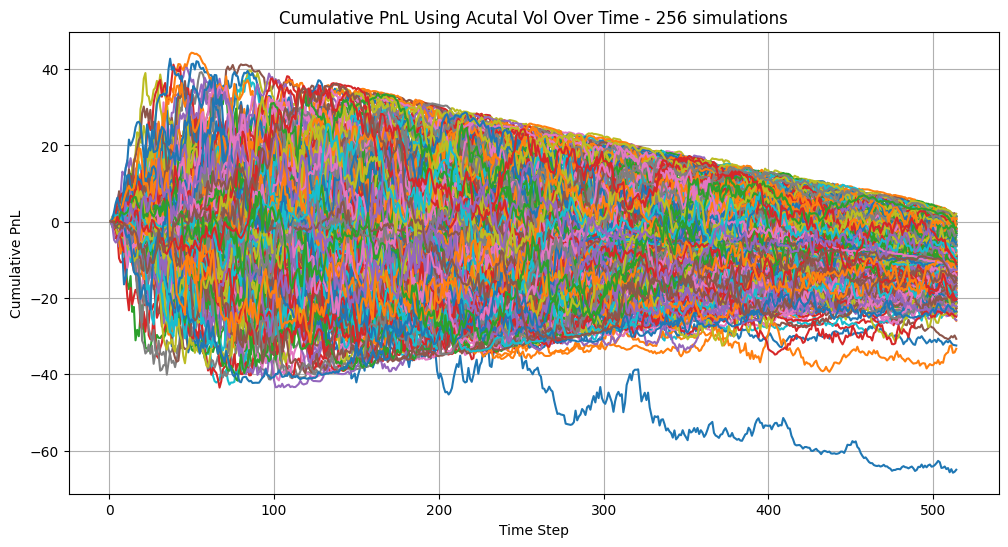

In [41]:
# plot the daily pnl of all simulations
mc_256sim = MCOptionPricing(100,100,0.05,0.20,0.35,1,256)
daily_pnl_256sim_actual = mc_256sim.pnl_cum()
time_steps = np.arange(1,515)

plt.figure(figsize =(12,6))

for i in range(daily_pnl_256sim_actual.shape[0]):
    plt.plot(time_steps, daily_pnl_256sim_actual[i,:], label = f'Simulation {i + 1}')

plt.xlabel('Time Step')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL Using Acutal Vol Over Time - 256 simulations')
plt.grid(True)
plt.show()

## 4.2 Hedging with $\Delta_{implied}$

S: [[100.         100.01584145 100.00565628 ... 101.02127529 101.01367726
  101.00568585]
 [100.         100.00403908 100.00571688 ... 101.4160651  101.59757141
  101.6273153 ]
 [100.         100.00205164 100.00490876 ... 101.32281439 101.30942423
  101.32728271]
 ...
 [100.         100.002088   100.02386694 ... 101.02708105 101.04359813
  101.03081492]
 [100.         100.00421778 100.01623456 ... 101.00511315 101.02086065
  101.03388108]
 [100.         100.01977051 100.03466434 ... 101.00667022 101.00645651
  101.0127389 ]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.35
T: 1
d1: [[0.01402008 0.02428071 0.01768388 ... 0.67220518 0.66733306 0.66220829]
 [0.01402008 0.01663637 0.01772313 ... 0.92485522 1.04068231 1.05964345]
 [0.01402008 0.01534904 0.01719969 ... 0.86526724 0.85670632 0.86812379]
 ...
 [0.01402008 0.01537259 0.02947826 ... 0.67592779 0.68651724 0.6783218 ]
 [0.01402008 0.01675213 0.0245353  ... 0.66184101 0.67193931 0.68028764]
 [0.01402008 0.02682534 0.03647033 ... 0.66

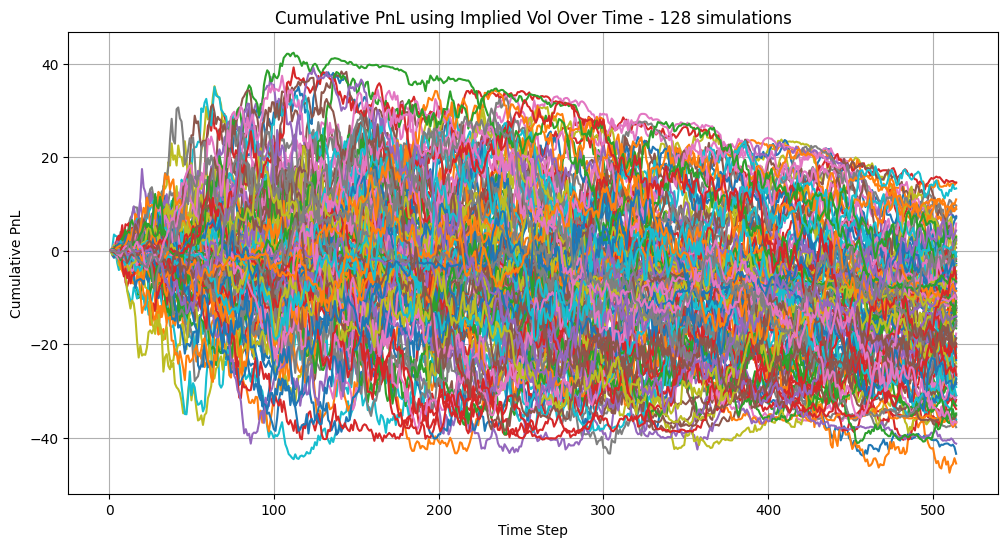

In [42]:
# plot the daily pnl of all simulations
daily_pnl_128sim_implied = mc_128sim.pnl_cum(use_implied_vol=True)
time_steps = np.arange(1,515)

plt.figure(figsize =(12,6))

for i in range(daily_pnl_128sim_implied.shape[0]):
    plt.plot(time_steps, daily_pnl_128sim_implied[i,:], label = f'Simulation {i + 1}')

plt.xlabel('Time Step')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL using Implied Vol Over Time - 128 simulations')
plt.grid(True)
plt.show()

S: [[100.         100.00838325 100.01291971 ... 101.05813499 101.06536807
  101.041802  ]
 [100.         100.00243586 100.01579693 ... 101.06249746 101.0382919
  101.06565332]
 [100.         100.01152996 100.00455712 ... 101.60517948 101.61548333
  101.65337971]
 ...
 [100.         100.01119597 100.03075943 ... 101.0994967  101.11720346
  101.19065651]
 [100.         100.0024118  100.0055369  ... 103.54081727 104.04727547
  103.97977945]
 [100.         100.00863586 100.00682549 ... 105.67043532 105.85780678
  105.7736257 ]]
S.shape: (256, 514)
K: 100
r: 0.05
sigma: 0.35
T: 1
d1: [[0.01402008 0.01945017 0.0223884  ... 0.6958357  0.70047177 0.68536578]
 [0.01402008 0.01559791 0.02425187 ... 0.69863188 0.68311549 0.7006546 ]
 [0.01402008 0.02148829 0.01697192 ... 1.04553283 1.05210147 1.07625443]
 ...
 [0.01402008 0.02127196 0.03394172 ... 0.72234217 0.73368615 0.78072325]
 [0.01402008 0.01558232 0.01760656 ... 2.26794438 2.58401603 2.54198192]
 [0.01402008 0.01961379 0.0184412  ... 3.586

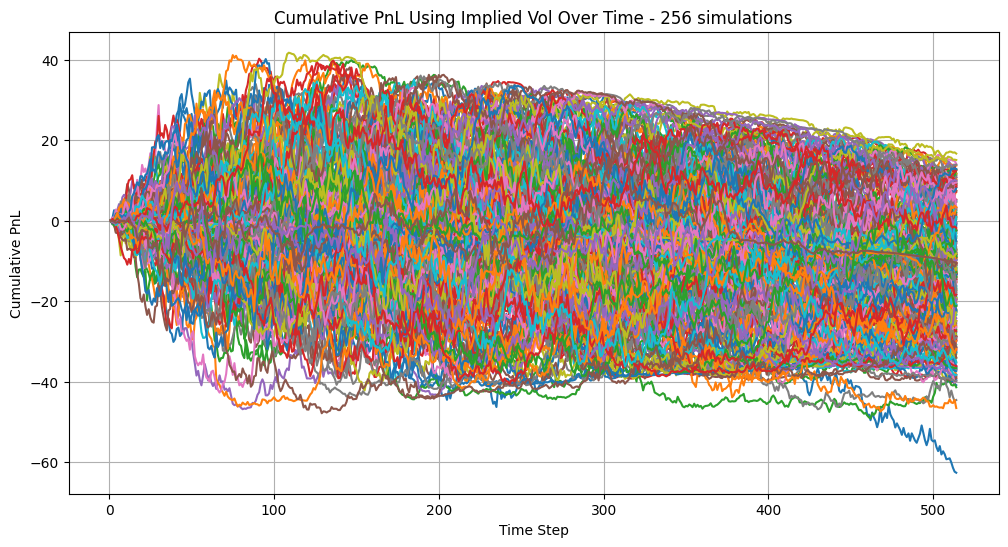

In [43]:
# plot the daily pnl of all simulations
mc_256sim = MCOptionPricing(100,100,0.05,0.20,0.35,1,256)
daily_pnl_256sim_implied = mc_256sim.pnl_cum(use_implied_vol=True)
time_steps = np.arange(1,515)

plt.figure(figsize =(12,6))

for i in range(daily_pnl_256sim_implied.shape[0]):
    plt.plot(time_steps, daily_pnl_256sim_implied[i,:], label = f'Simulation {i + 1}')

plt.xlabel('Time Step')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL Using Implied Vol Over Time - 256 simulations')
plt.grid(True)
plt.show()

## 6. PnL decomposes to Greeks (Gamma)

This exercise is to decompose the PnL in terms of Greeks\\

$d PnL_t = \frac{1}{2}\Gamma_{t}  S_t^2[r_t^2 - \simga_{t,imp}\Delta t]$

## 6.1 Sense check

In [44]:
mc_128sim_gamma = mc_128sim.gamma()

S: [[100.         100.0019571  100.00445312 ... 104.24748805 103.89621047
  104.04803332]
 [100.         100.00196503 100.00625682 ... 101.79328355 101.77948391
  101.92774822]
 [100.         100.00582542 100.00463289 ... 104.79142066 105.07547631
  105.07777413]
 ...
 [100.         100.00556761 100.01316004 ... 101.29928905 101.42530651
  101.48205535]
 [100.         100.00195624 100.00404777 ... 103.87735815 103.80351
  104.02451032]
 [100.         100.00196912 100.02063848 ... 111.10583834 110.67210562
  111.59820049]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[ 0.01543784  0.01765634  0.02048568 ...  4.73084956  4.34822826
   4.51375642]
 [ 0.01543784  0.01766534  0.02253021 ...  2.03025318  2.01488475
   2.17989534]
 [ 0.01543784  0.02204122  0.02068947 ...  5.32077959  5.62764032
   5.63011923]
 ...
 [ 0.01543784  0.02174899  0.03035479 ...  1.47879766  1.61972846
   1.68313597]
 [ 0.01543784  0.01765537  0.02002621 ...  4.32765723  4.24704059
   4.48812578]
 [ 0.01

In [45]:
mc_128sim_gamma

array([[4.52178468e-01, 4.52153019e-01, 4.52117338e-01, ...,
        5.98876382e-06, 3.41302687e-05, 1.63670543e-05],
       [4.52178468e-01, 4.52152912e-01, 4.52089303e-01, ...,
        5.65688327e-02, 5.83627276e-02, 4.12285197e-02],
       [4.52178468e-01, 4.52096180e-01, 4.52114628e-01, ...,
        3.07217884e-07, 5.71129078e-08, 5.63202852e-08],
       ...,
       [4.52178468e-01, 4.52100238e-01, 4.51964577e-01, ...,
        1.49585126e-01, 1.20095050e-01, 1.08095053e-01],
       [4.52178468e-01, 4.52153031e-01, 4.52123378e-01, ...,
        3.73227127e-05, 5.27701081e-05, 1.83725649e-05],
       [4.52178468e-01, 4.52152856e-01, 4.51798294e-01, ...,
        3.82203659e-32, 6.96773143e-30, 8.38985677e-35]])

In [46]:
mc_128sim.asset_return

array([[ 0.00000000e+00,  1.95340388e-05, -1.41039633e-05, ...,
         6.77172980e-03,  6.68310265e-03,  6.42753290e-03],
       [ 0.00000000e+00,  2.16531030e-05,  2.48298370e-05, ...,
         1.64405708e-02,  1.82557535e-02,  1.92739131e-02],
       [ 0.00000000e+00,  2.28925898e-04,  3.23702141e-05, ...,
        -5.77457156e-03, -7.93505118e-03, -8.57656551e-03],
       ...,
       [ 0.00000000e+00,  2.48204302e-04,  3.76564866e-04, ...,
        -4.32884781e-02, -4.04260708e-02, -4.26986053e-02],
       [ 0.00000000e+00,  2.23261143e-05,  2.00588834e-05, ...,
        -3.46206339e-02, -3.58574856e-02, -3.48470609e-02],
       [ 0.00000000e+00,  1.96934899e-05, -5.59546875e-06, ...,
        -5.04911951e-02, -5.08540219e-02, -5.00672266e-02]])

In [47]:
mc_128sim.asset_return.shape

(128, 514)

In [48]:
mc_128sim.ret_vol_diff

array([[-0.00068093, -0.00068093, -0.00068093, ...,  0.01329056,
         0.01223838,  0.01249283],
       [-0.00068093, -0.00068093, -0.00068089, ..., -0.00066064,
        -0.00066004, -0.00067125],
       [-0.00068093, -0.00068089, -0.00068089, ..., -0.00059239,
        -0.0004918 , -0.00051084],
       ...,
       [-0.00068093, -0.00068091, -0.00068093, ..., -0.00059178,
        -0.00058171, -0.00053237],
       [-0.00068093, -0.00068093, -0.00068093, ..., -0.00067891,
        -0.00067492, -0.00067135],
       [-0.00068093, -0.00068093, -0.00068093, ...,  0.00157436,
         0.0012356 ,  0.0010271 ]])

S: [[100.         100.00323569 100.00846357 ... 101.1536347  101.22748156
  101.17284008]
 [100.         100.00205186 100.00895187 ... 104.77010011 105.19205747
  105.14311349]
 [100.         100.02530387 100.01183134 ... 101.60840102 101.58773142
  101.54286135]
 ...
 [100.         100.02460115 100.02997883 ... 101.03340383 101.0521886
  101.05771981]
 [100.         100.00208342 100.00392636 ... 101.03718573 101.06901809
  101.05835621]
 [100.         100.00307109 100.01109156 ... 102.00262797 102.09418374
  101.93993133]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01910569 0.02503156 ... 1.31568749 1.3984138  1.33720796]
 [0.01543784 0.01776376 0.02558503 ... 5.29771379 5.75334104 5.70058539]
 [0.01543784 0.04411813 0.02884879 ... 1.82417927 1.80111721 1.75103737]
 ...
 [0.01543784 0.04332174 0.0494161  ... 1.18087061 1.20194485 1.20814946]
 [0.01543784 0.01779953 0.01988859 ... 1.18511375 1.22082219 1.20886332]
 [0.01543784 0.0189191  0.02801029 ... 2.2631

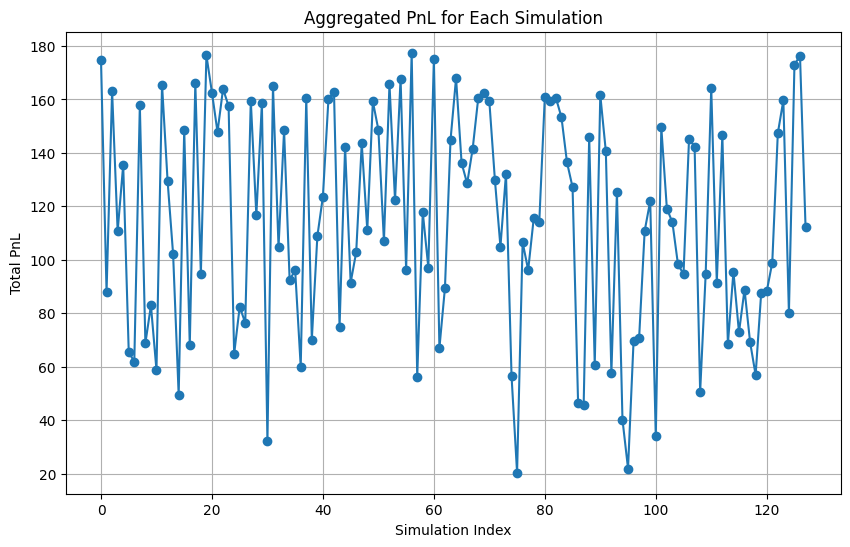

In [49]:
#total PnL
total_pnl = np.sum(mc_128sim.pnl_gamma_discounted(), axis = 1)
plt.figure(figsize = (10,6))
plt.plot(total_pnl, marker = 'o', linestyle = '-')
plt.title('Aggregated PnL for Each Simulation')
plt.xlabel('Simulation Index')
plt.ylabel('Total PnL')
plt.grid(True)
plt.show()

## 6.2 Time-dependent $\Gamma_t$

### 6.2.1 Using actual vol

S: [[100.         100.00407758 100.00644919 ... 108.96426734 109.7128127
  109.4951737 ]
 [100.         100.01096136 100.01916772 ... 107.29828081 107.52275179
  107.23756618]
 [100.         100.00195355 100.00852458 ... 101.30079421 101.34332398
  101.46083156]
 ...
 [100.         100.00196116 100.00723096 ... 102.93134136 102.93193125
  102.80590884]
 [100.         100.01016016 100.00652445 ... 101.5946371  101.43473725
  101.60669693]
 [100.         100.00428606 100.00509852 ... 101.29330301 101.24012062
  101.25218482]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[ 0.01543784  0.02006001  0.02274826 ...  9.74718803 10.52325306
  10.29816002]
 [ 0.01543784  0.02786271  0.03716387 ...  8.00064085  8.23754089
   7.93647928]
 [ 0.01543784  0.01765232  0.0251007  ...  1.48048199  1.52806375
   1.65942603]
 ...
 [ 0.01543784  0.01766094  0.02363441 ...  3.29057157  3.29122122
   3.15234905]
 [ 0.01543784  0.02695459  0.02283357 ...  1.80882273  1.63026822
   1.82227812]
 [ 0.

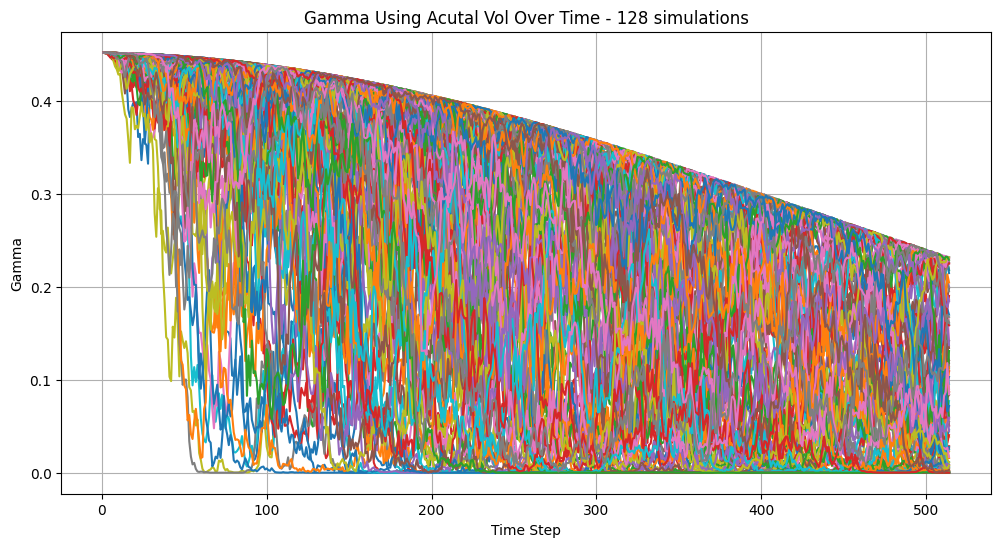

In [50]:
# the simulations of Gamma over time
mc_128sim_gamma = mc_128sim.gamma()
time_steps = np.arange(1,515)

plt.figure(figsize =(12,6))

for i in range(mc_128sim_gamma.shape[0]):
    plt.plot(time_steps, mc_128sim_gamma[i,:], label = f'Simulation {i + 1}')

plt.xlabel('Time Step')
plt.ylabel('Gamma')
plt.title('Gamma Using Acutal Vol Over Time - 128 simulations')
plt.grid(True)
plt.show()

S: [[100.         100.00384887 100.0237921  ... 101.71092877 101.61497346
  101.67663041]
 [100.         100.002467   100.0119826  ... 101.75828056 101.74912293
  101.81214171]
 [100.         100.00629337 100.00483902 ... 101.14515355 101.30497343
  101.37722832]
 ...
 [100.         100.00601692 100.01421642 ... 101.14297767 101.20074474
  101.28448866]
 [100.         100.00252763 100.00532578 ... 103.04150188 103.12954575
  103.11679046]
 [100.         100.00372238 100.01264647 ... 101.96576929 102.16721073
  102.16308877]]
S.shape: (128, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01980075 0.04240484 ... 1.93850511 1.83151148 1.90027279]
 [0.01543784 0.01823434 0.02902024 ... 1.99126687 1.98106488 2.05125184]
 [0.01543784 0.02257164 0.02092311 ... 1.30618269 1.48515853 1.5659812 ]
 ...
 [0.01543784 0.02225828 0.03155212 ... 1.30374406 1.36846908 1.46223425]
 [0.01543784 0.01830307 0.02147487 ... 3.411826   3.50864332 3.4946221 ]
 [0.01543784 0.01965737 0.02977269 ... 2.222

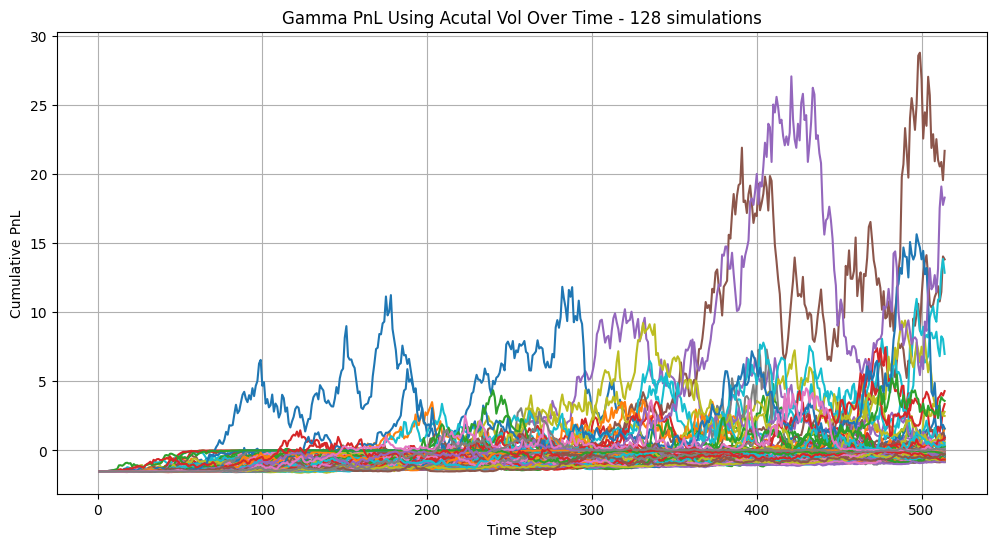

In [51]:
# plot the daily pnl of all simulations
mc_128sim = MCOptionPricing(100,100,0.05,0.20,0.35,1,128)
daily_pnl_128sim_gamma = mc_128sim.pnl_gamma()
time_steps = np.arange(1,515)

plt.figure(figsize =(12,6))

for i in range(daily_pnl_128sim_gamma.shape[0]):
    plt.plot(time_steps, daily_pnl_128sim_gamma[i,:], label = f'Simulation {i + 1}')

plt.xlabel('Time Step')
plt.ylabel('Cumulative PnL')
plt.title('Gamma PnL Using Acutal Vol Over Time - 128 simulations')
plt.grid(True)
plt.show()

S: [[100.         100.00561648 100.00397621 ... 101.36847596 101.34255779
  101.38092248]
 [100.         100.00199118 100.01773813 ... 107.8030453  107.5794487
  107.99069089]]
S.shape: (2, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.02180438 0.0199451  ... 1.55619408 1.52720673 1.57011185]
 [0.01543784 0.01769497 0.03554362 ... 8.53266098 8.29729889 8.72980391]]
delta: [[4.52178468e-01 4.52099472e-01 4.52124435e-01 ... 1.32918231e-01
  1.39028599e-01 1.30041775e-01]
 [4.52178468e-01 4.52152557e-01 4.51866628e-01 ... 6.50193588e-17
  4.72165041e-16 1.18385299e-17]]


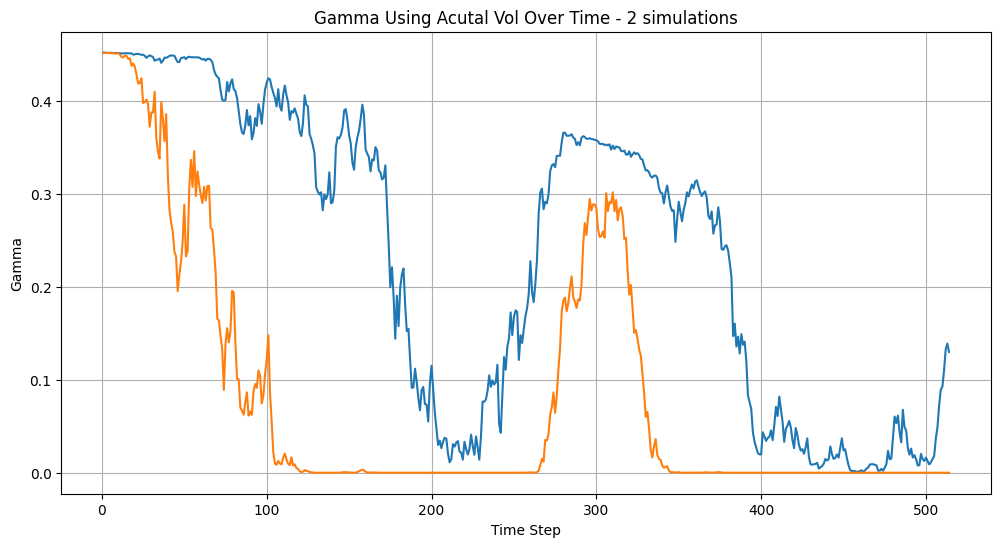

In [52]:
# the simulations of Gamma over time
mc_2sim_gamma = mc_2sim.gamma()
time_steps = np.arange(1,515)

plt.figure(figsize =(12,6))

for i in range(mc_2sim_gamma.shape[0]):
    plt.plot(time_steps, mc_2sim_gamma[i,:], label = f'Simulation {i + 1}')

plt.xlabel('Time Step')
plt.ylabel('Gamma')
plt.title('Gamma Using Acutal Vol Over Time - 2 simulations')
plt.grid(True)
plt.show()

S: [[100.         100.00649739 100.02626597 ... 101.8206044  102.03843672
  101.94821601]
 [100.         100.00350309 100.00550847 ... 110.80397651 110.86528173
  110.81775212]]
S.shape: (2, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[ 0.01543784  0.0228029   0.04520847 ...  2.06067382  2.30292956
   2.20265608]
 [ 0.01543784  0.01940879  0.02168195 ... 11.64509945 11.70780032
  11.65919169]]
delta: [[4.52178468e-01 4.52085421e-01 4.51651822e-01 ... 5.31418901e-02
  3.12579719e-02 3.92148064e-02]
 [4.52178468e-01 4.52131345e-01 4.52101164e-01 ... 1.45824040e-30
  7.00860649e-31 1.23726260e-30]]


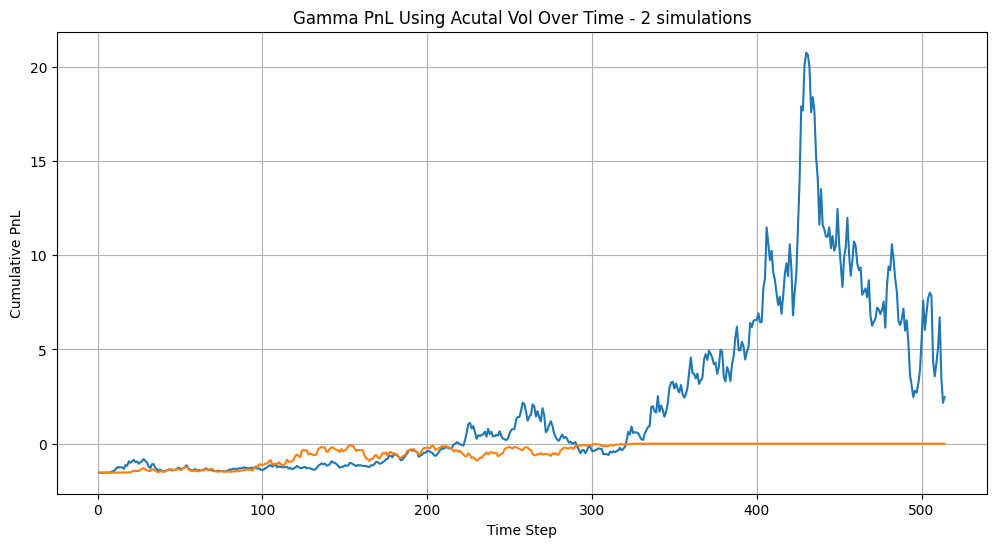

In [53]:
# the simulations of PnL
# plot the daily pnl of all simulations
mc_2sim = MCOptionPricing(100,100,0.05,0.20,0.35,1,2)
daily_pnl_2sim_gamma = mc_2sim.pnl_gamma()
time_steps = np.arange(1,515)

plt.figure(figsize =(12,6))

for i in range(daily_pnl_2sim_gamma.shape[0]):
    plt.plot(time_steps, daily_pnl_2sim_gamma[i,:], label = f'Simulation {i + 1}')

plt.xlabel('Time Step')
plt.ylabel('Cumulative PnL')
plt.title('Gamma PnL Using Acutal Vol Over Time - 2 simulations')
plt.grid(True)
plt.show()

S: [[100.         100.00195917 100.00608086 ... 102.07880237 101.92420492
  101.98017539]
 [100.         100.00372044 100.0059733  ... 103.08783461 103.05137585
  103.12719605]]
S.shape: (2, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01765868 0.02233076 ... 2.34776421 2.17595462 2.23818666]
 [0.01543784 0.01965517 0.02220884 ... 3.46278603 3.42268802 3.50606054]]
delta: [[0.45217847 0.45215299 0.45209212 ... 0.02815212 0.04158534 0.03622857]
 [0.45217847 0.45212819 0.45209383 ... 0.00109236 0.00125451 0.00093911]]
S: [[100.         100.0035943  100.00919622 ... 106.73840826 107.04917845
  107.44052014]
 [100.         100.00195862 100.00395242 ... 101.57283604 101.6496506
  101.69743031]]
S.shape: (2, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01951219 0.025862   ... 7.40760152 7.73716474 8.15081349]
 [0.01543784 0.01765806 0.01991813 ... 1.78449481 1.87018939 1.92345994]]
delta: [[4.52178468e-01 4.52130023e-01 4.52039572e-01 ... 5.14773076e-13
  4.23191601e-14 1

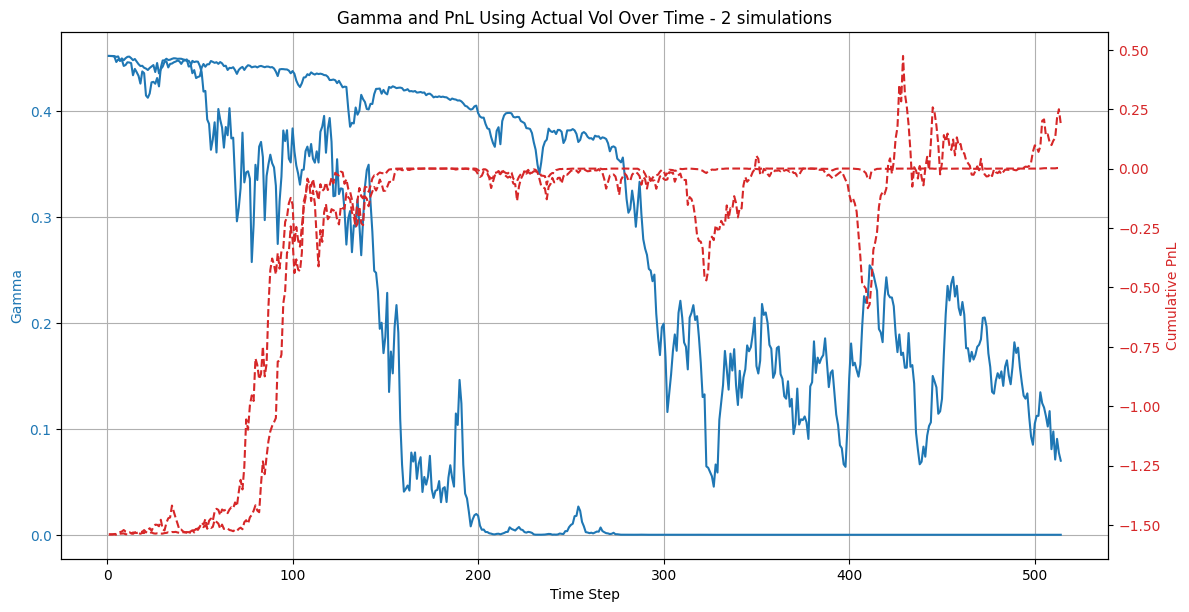

In [54]:
# the simulations of PnL
# plot the daily pnl of all simulations
mc_2sim = MCOptionPricing(100,100,0.05,0.20,0.35,1,2)
daily_pnl_2sim_gamma = mc_2sim.pnl_gamma()
time_steps = np.arange(1,515)
mc_2sim_gamma = mc_2sim.gamma()


fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Gamma over time on the primary y-axis
color = 'tab:blue'
for i in range(mc_2sim_gamma.shape[0]):
    ax1.plot(time_steps, mc_2sim_gamma[i, :], label=f'Gamma Simulation {i + 1}', color=color)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Gamma', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Create a secondary y-axis for the PnL
ax2 = ax1.twinx()
color = 'tab:red'
for i in range(daily_pnl_2sim_gamma.shape[0]):
    ax2.plot(time_steps, daily_pnl_2sim_gamma[i, :], label=f'PnL Simulation {i + 1}', linestyle='--', color=color)
ax2.set_ylabel('Cumulative PnL', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Gamma and PnL Using Actual Vol Over Time - 2 simulations')
plt.show()

Average Gamma: [0.45217847 0.45214151 0.45208218 0.45172482 0.44886957 0.45025388
 0.44769667 0.44923988 0.44541574 0.4468314  0.44874305 0.44878239
 0.44774622 0.44106728 0.44461138 0.44186043 0.43887803 0.43433529
 0.44022309 0.43846591 0.42754499 0.42581075 0.42878071 0.4347282
 0.43563219 0.43146594 0.43841769 0.42955178 0.44046065 0.44500576
 0.44726021 0.44830914 0.44483711 0.4466187  0.44721857 0.44808261
 0.44835725 0.44862688 0.4483565  0.44707711 0.44816857 0.44825218
 0.44814687 0.44493426 0.44383227 0.44170412 0.44258122 0.43911306
 0.43954033 0.43795139 0.43905543 0.43154889 0.4305911  0.4182466
 0.41616241 0.40546519 0.40990867 0.41758876 0.40363602 0.4233846
 0.41920701 0.41488482 0.40409757 0.41399643 0.40810772 0.42190028
 0.40749461 0.408253   0.387716   0.36561068 0.37383803 0.3841484
 0.41077459 0.38586799 0.3919504  0.39332564 0.38956914 0.34948446
 0.36735135 0.39581162 0.3881834  0.40444918 0.40688349 0.39942363
 0.36934679 0.39048401 0.39595471 0.40017072 0.3962

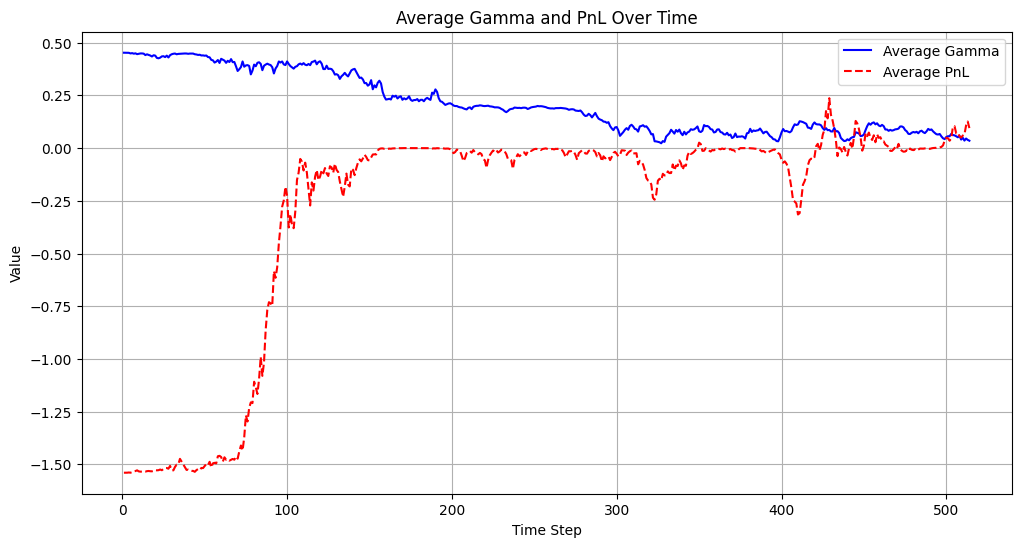

In [55]:
# Assuming mc_2sim_gamma and daily_pnl_2sim_gamma are already defined

# Calculate the average across the two simulations
average_gamma = np.mean(mc_2sim_gamma, axis=0)
average_pnl = np.mean(daily_pnl_2sim_gamma, axis=0)

# Print the averages for debugging (optional)
print("Average Gamma:", average_gamma)
print("Average PnL:", average_pnl)

# Time steps
time_steps = np.arange(1, 515)

# Plotting the averaged lines
plt.figure(figsize=(12, 6))

# Plot the average Gamma
plt.plot(time_steps, average_gamma, label='Average Gamma', color='blue')

# Plot the average PnL on the same graph
plt.plot(time_steps, average_pnl, label='Average PnL', color='red', linestyle='--')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Average Gamma and PnL Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 6.3 Return - implied vol * timestep

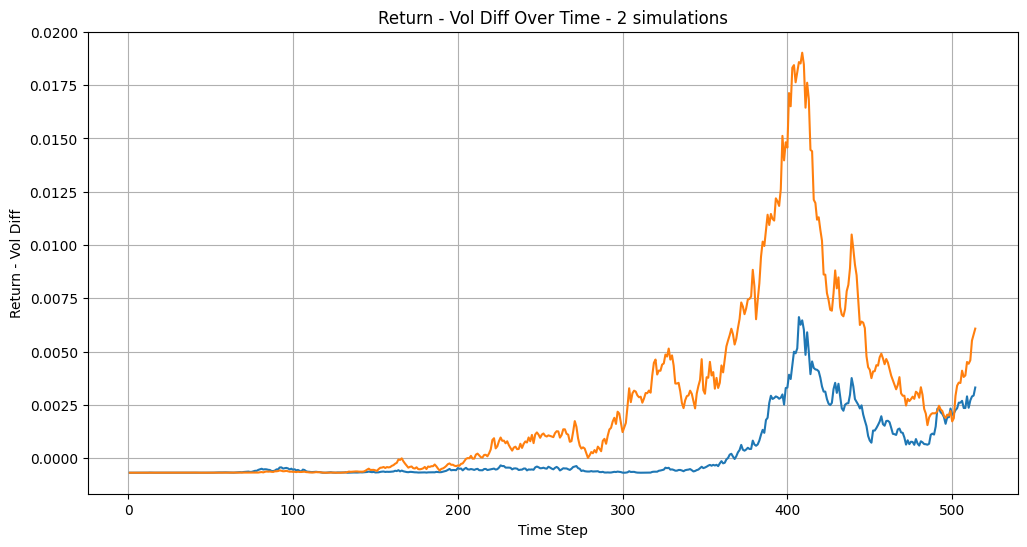

In [56]:
# the simulations of Return - implied vol * timestep over time
mc_2sim_rvol_diff = mc_2sim.ret_vol_diff
time_steps = np.arange(1,515)

plt.figure(figsize =(12,6))

for i in range(mc_2sim_rvol_diff.shape[0]):
    plt.plot(time_steps, mc_2sim_rvol_diff[i,:], label = f'Simulation {i + 1}')

plt.xlabel('Time Step')
plt.ylabel('Return - Vol Diff')
plt.title('Return - Vol Diff Over Time - 2 simulations')
plt.grid(True)
plt.show()

S: [[100.         100.00242332 100.01604755 ... 103.12320621 103.0100197
  103.50353483]
 [100.         100.00978644 100.02224291 ... 103.33940162 103.33020748
  103.49099094]]
S.shape: (2, 514)
K: 100
r: 0.05
sigma: 0.2
T: 1
d1: [[0.01543784 0.01818482 0.03362754 ... 3.50167481 3.37718658 3.91898072]
 [0.01543784 0.026531   0.04064912 ... 3.73907813 3.72899219 3.90524173]]
delta: [[4.52178468e-01 4.52146629e-01 4.51904212e-01 ... 9.53685424e-04
  1.46498561e-03 2.02008716e-04]
 [4.52178468e-01 4.52028983e-01 4.51758401e-01 ... 4.02924909e-04
  4.18426158e-04 2.13189307e-04]]


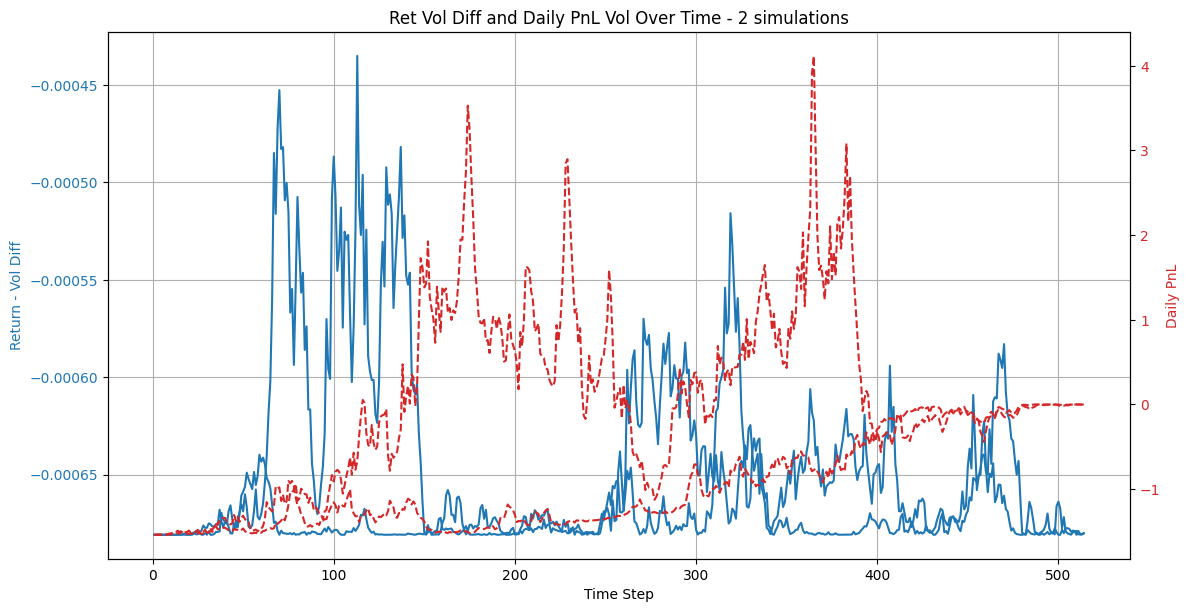

In [57]:
# the simulations of PnL
# plot the daily pnl of all simulations
mc_2sim = MCOptionPricing(100,100,0.05,0.20,0.35,1,2)
daily_pnl_2sim_gamma = mc_2sim.pnl_gamma()
time_steps = np.arange(1,515)
mc_2sim_rvol_diff = mc_2sim.ret_vol_diff


fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Gamma over time on the primary y-axis
color = 'tab:blue'
for i in range(mc_2sim_rvol_diff.shape[0]):
    ax1.plot(time_steps, mc_2sim_rvol_diff[i, :], label=f'Gamma Simulation {i + 1}', color=color)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Return - Vol Diff', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Create a secondary y-axis for the PnL
ax2 = ax1.twinx()
color = 'tab:red'
for i in range(daily_pnl_2sim_gamma.shape[0]):
    ax2.plot(time_steps, daily_pnl_2sim_gamma[i, :], label=f'PnL Simulation {i + 1}', linestyle='--', color=color)
ax2.set_ylabel('Daily PnL', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Ret Vol Diff and Daily PnL Vol Over Time - 2 simulations')
plt.show()